# Wielowarstwowa sieć neuronowa

(*Multilayer perceptron*, *feedforward neural network*)



**Uwaga:** "Input layer" pomimo tego, że ma w nazwie słowo "warstwa", to tak naprawdę to nie jest żadna warstwa sieci... To są po prostu dane wejściowe... Niestety przyjęło się literaturze nazywanie tego w ten sposób, co jest mylące :(


Sieci uczy sie metodą spadku gradientu (pewnymi wariantami tej metody). Uczenie wykorzystuje algorytm **propagacji wstecznej** (https://en.wikipedia.org/wiki/Backpropagation).

<br>

<br>

<br>

**Uwaga!** Sieci neuronowe absolutnie zawsze wymagają zestandaryzowanych danych! Niezależnie od tego czy wykorzystujemy regularyzację czy nie i niezależnie od typu sieci!

<br>

<br>

### Fakt matematyczny: jednowarstwową siecią możemy otrzymać dowolny kształt. 

Co z tego wynika? To, że (teoretycznie) zawsze wystarczy sieć jednowarstwowa (odpowiednio duża). W praktyce rzeczywiście z reguły wystarcza jedna warstwa, ale mimo wszystko zawsze warto sprawdzić czy 2 (lub 3) nie zadziałają przypadkiem lepiej. Przy czym jeżeli dla dwóch wartsw jest gorzej, to nie ma sensu sprawdzać dla większej ilości.

In [1]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score


from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# Zad
* Wczytaj zbiór danych - pima-indians-diabetes.data
* Podziel dane na train test
* Wykonaj uczenie modeli (dobierz najlepsze parametry)
    * LogisticRegression
    * LinearSVC
    * SVC
    * KNeighborsClassifier
    * DecisionTreeClassifier
    * RandomForestClassifier
    * BaggingClassifier
    * ExtraTreesClassifier
    * AdaBoostClassifier
    * GradientBoostingClassifier
    * VotingClassifier
    * xgboost.XGBClassifier
* Porównaj wyniki na zbiorze uczącym    

In [10]:
import pandas as pd

column_names = [
    "pregnancies",
    "glucose",
    "blood_pressure",
    "skin_thickness",
    "insulin",
    "BMI",
    "diabetes_pedigree_function",
    "age",
    "class",
]
data = pd.read_csv(
    "diabetes.csv", header=None, names=column_names,skiprows=1
)


X = data.iloc[:, :-1]
y = data.iloc[:, -1]

print(X.head())
print(y.head())

   pregnancies  glucose  blood_pressure  skin_thickness  insulin   BMI  \
0            6      148              72              35        0  33.6   
1            1       85              66              29        0  26.6   
2            8      183              64               0        0  23.3   
3            1       89              66              23       94  28.1   
4            0      137              40              35      168  43.1   

   diabetes_pedigree_function  age  
0                       0.627   50  
1                       0.351   31  
2                       0.672   32  
3                       0.167   21  
4                       2.288   33  
0    1
1    0
2    1
3    0
4    1
Name: class, dtype: int64


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
)
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score


models = {
    "LogisticRegression": LogisticRegression(),
    "LinearSVC": LinearSVC(),
    "SVC": SVC(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "BaggingClassifier": BaggingClassifier(),
    "ExtraTreesClassifier": ExtraTreesClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "XGBClassifier": XGBClassifier(),
    "MLPClassifier": MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=1000),
}


param_grids = {
    "LogisticRegression": {"C": [0.01, 0.1, 1, 10, 100]},
    "LinearSVC": {"C": [0.01, 0.1, 1, 10, 100]},
    "SVC": {"C": [0.01, 0.1, 1, 10, 100], "kernel": ["linear", "rbf"]},
    "KNeighborsClassifier": {"n_neighbors": [3, 5, 7, 9]},
    "DecisionTreeClassifier": {"max_depth": [None, 10, 20, 30]},
    "RandomForestClassifier": {"n_estimators": [50, 100, 200]},
    "BaggingClassifier": {"n_estimators": [50, 100, 200]},
    "ExtraTreesClassifier": {"n_estimators": [50, 100, 200]},
    "AdaBoostClassifier": {"n_estimators": [50, 100, 200]},
    "GradientBoostingClassifier": {"n_estimators": [50, 100, 200]},
    "XGBClassifier": {"n_estimators": [50, 100, 200]},
    "MLPClassifier": {
        "hidden_layer_sizes": [(20, 10), (50, 25)],
        "learning_rate_init": [0.001, 0.01],
        "max_iter": [500, 1000],
    },
}

# Definiowanie StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


def train_and_evaluate_models(X_train, y_train, X_test, y_test, scaled=False):
    results = []
    for model_name, model in models.items():
        print(f"Trening modelu: {model_name}")
        grid = GridSearchCV(
            estimator=model,
            param_grid=param_grids[model_name],
            cv=kfold,
            scoring="accuracy",
            n_jobs=-1,
        )
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_

        # Walidacja krzyżowa
        cv_results = cross_val_score(
            best_model, X_train, y_train, cv=kfold, scoring="accuracy"
        )
        print(
            f"{model_name} - Cross-validation accuracy: {cv_results.mean():.4f} (+/- {cv_results.std():.4f})"
        )

        y_pred = best_model.predict(X_test)
        y_prob = (
            best_model.predict_proba(X_test)[:, 1]
            if hasattr(best_model, "predict_proba")
            else best_model.decision_function(X_test)
        )

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob)

        results.append(
            {
                "Model": model_name + (" (scaled)" if scaled else " (original)"),
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1 Score": f1,
                "ROC AUC": roc_auc,
            }
        )

    return results

# MLPClassifier

Dodajmy model sieci neuronowej

# Zad
Wykonaj Walidację krzyżową

# Wczytaj dane treningowe i testowe

In [12]:
# Wczytaj dane treningowe i testowe

import pandas as pd

train_set = pd.read_csv('Dane/adult/adult.data', sep=", ",header = None)
test_set = pd.read_csv('Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set


col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()



dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

# print(X_train.shape)
# X_test.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [13]:
print(X_train.shape)
print(X_test.shape)

(30162, 41)
(15060, 41)


# Zad
Porównaj wyniki sieci na:
* oryginalnych danych 
* na wystandaryzowanych

Trening modelu: LogisticRegression
LogisticRegression - Cross-validation accuracy: 0.7722 (+/- 0.0471)
Trening modelu: LinearSVC


/home/sit3kk/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/sit3kk/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/sit3kk/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/sit3kk/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/sit3kk/anaconda3/l

LinearSVC - Cross-validation accuracy: 0.7683 (+/- 0.0566)
Trening modelu: SVC
SVC - Cross-validation accuracy: 0.7664 (+/- 0.0438)
Trening modelu: KNeighborsClassifier
KNeighborsClassifier - Cross-validation accuracy: 0.7741 (+/- 0.0604)
Trening modelu: DecisionTreeClassifier
DecisionTreeClassifier - Cross-validation accuracy: 0.7197 (+/- 0.0322)
Trening modelu: RandomForestClassifier
RandomForestClassifier - Cross-validation accuracy: 0.7702 (+/- 0.0516)
Trening modelu: BaggingClassifier
BaggingClassifier - Cross-validation accuracy: 0.7547 (+/- 0.0398)
Trening modelu: ExtraTreesClassifier
ExtraTreesClassifier - Cross-validation accuracy: 0.7781 (+/- 0.0505)
Trening modelu: AdaBoostClassifier
AdaBoostClassifier - Cross-validation accuracy: 0.7586 (+/- 0.0525)
Trening modelu: GradientBoostingClassifier
GradientBoostingClassifier - Cross-validation accuracy: 0.7664 (+/- 0.0335)
Trening modelu: XGBClassifier
XGBClassifier - Cross-validation accuracy: 0.7625 (+/- 0.0421)
Trening modelu: 

/home/sit3kk/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sit3kk/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sit3kk/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sit3kk/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sit3kk/anaconda3/lib/python3.

MLPClassifier - Cross-validation accuracy: 0.7450 (+/- 0.0443)
Trening modelu: LogisticRegression


/home/sit3kk/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sit3kk/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

LogisticRegression - Cross-validation accuracy: 0.7800 (+/- 0.0472)
Trening modelu: LinearSVC


/home/sit3kk/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/sit3kk/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/sit3kk/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/sit3kk/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/sit3kk/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to 

LinearSVC - Cross-validation accuracy: 0.6847 (+/- 0.0468)
Trening modelu: SVC
SVC - Cross-validation accuracy: 0.7704 (+/- 0.0184)
Trening modelu: KNeighborsClassifier
KNeighborsClassifier - Cross-validation accuracy: 0.7470 (+/- 0.0357)
Trening modelu: DecisionTreeClassifier
DecisionTreeClassifier - Cross-validation accuracy: 0.7236 (+/- 0.0361)
Trening modelu: RandomForestClassifier
RandomForestClassifier - Cross-validation accuracy: 0.7781 (+/- 0.0441)
Trening modelu: BaggingClassifier
BaggingClassifier - Cross-validation accuracy: 0.7645 (+/- 0.0353)
Trening modelu: ExtraTreesClassifier
ExtraTreesClassifier - Cross-validation accuracy: 0.7742 (+/- 0.0376)
Trening modelu: AdaBoostClassifier
AdaBoostClassifier - Cross-validation accuracy: 0.7586 (+/- 0.0525)
Trening modelu: GradientBoostingClassifier
GradientBoostingClassifier - Cross-validation accuracy: 0.7664 (+/- 0.0341)
Trening modelu: XGBClassifier
XGBClassifier - Cross-validation accuracy: 0.7625 (+/- 0.0421)
Trening modelu: 

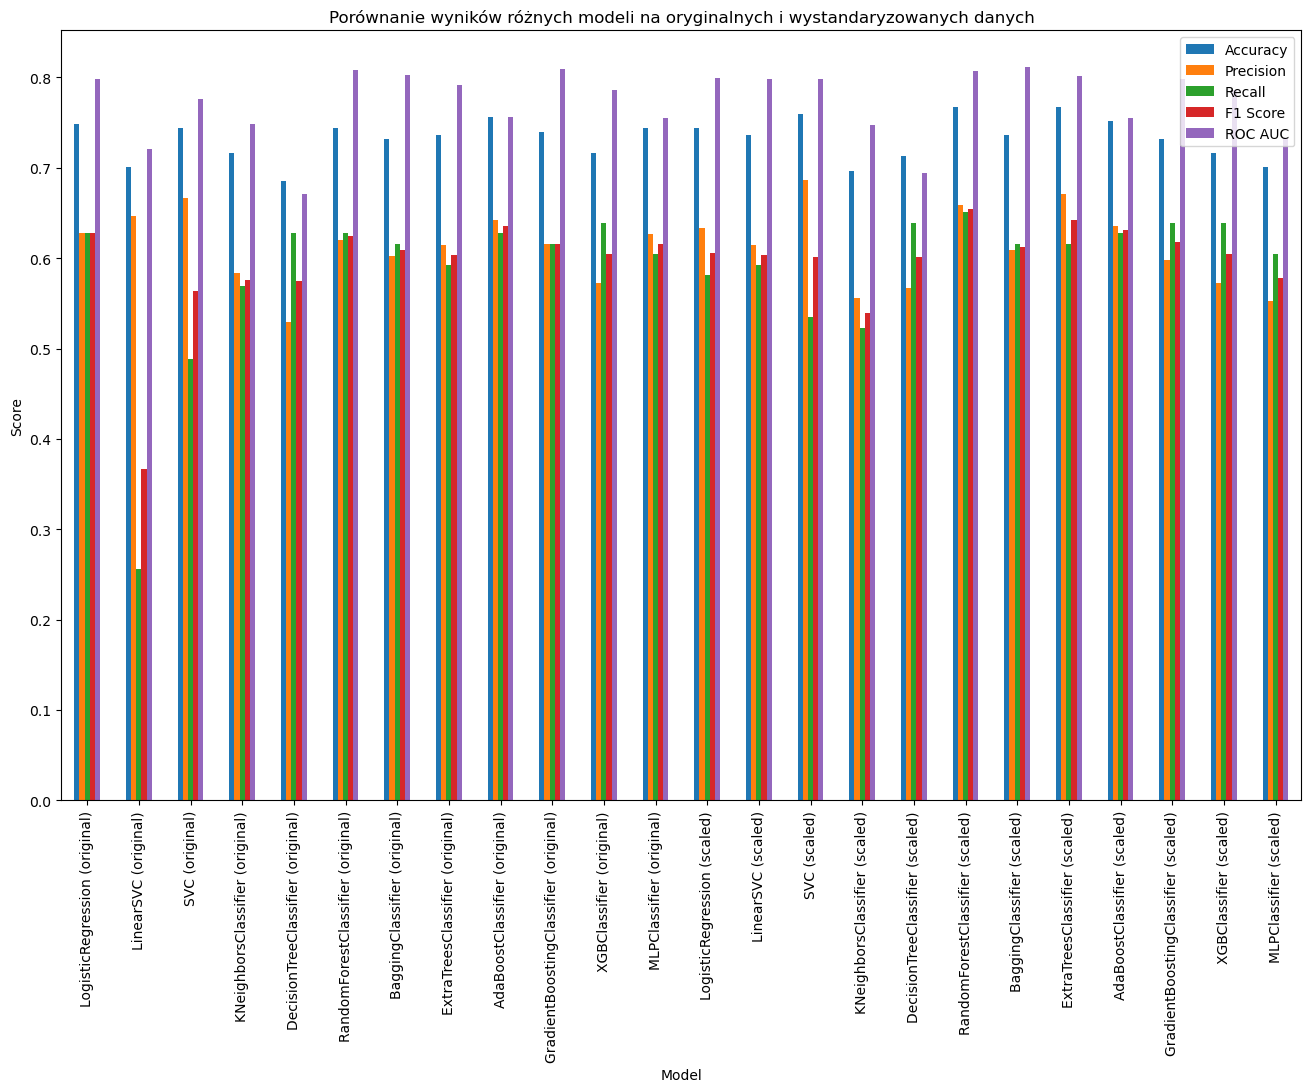

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

results_scaled = train_and_evaluate_models(
    X_train_scaled, y_train, X_test_scaled, y_test, scaled=True
)

results_original = train_and_evaluate_models(
    X_train, y_train, X_test, y_test, scaled=False
)


all_results = results_original + results_scaled
df_results = pd.DataFrame(all_results)
print(df_results)


df_results.set_index("Model").plot(kind="bar", figsize=(16, 10))
plt.title(
    "Porównanie wyników różnych modeli na oryginalnych i wystandaryzowanych danych"
)
plt.ylabel("Score")
plt.show()